In [1]:
###########################
#Noise QFT
# serach for the return probabilities
###########################

In [43]:
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister
from qiskit.quantum_info import Statevector
from qiskit import QuantumCircuit, execute
from qiskit.providers.aer import QasmSimulator
from qiskit.extensions import UnitaryGate
from qiskit.quantum_info.operators import Operator
from qiskit import execute, transpile, assemble
from qiskit import Aer
from qiskit.visualization import plot_state_city
from qiskit.visualization import plot_histogram
from sympy import factorint
from fractions import Fraction
from numpy import linalg
import pandas as pd
import numpy as np
from numpy import pi
from sympy import *
import random
import math

import qiskit.quantum_info as qi
from qiskit.visualization import array_to_latex
from qiskit.providers.aer.library import SaveDensityMatrix

from qiskit.quantum_info import Statevector

In [2]:
import matplotlib.pyplot as plt
plt.rc('figure', figsize=(16, 6))

In [3]:
def qft_rotations(circuit, n, n_max,  case, position):
    tmp = n_max - case
    
    if n == 0:
        return circuit
    n -= 1    

    if n  == tmp:
        errori(circuit, position, n)  
        
    circuit.h(n)   
    
    for qubit in range(n):
        circuit.cp(np.pi/2**(n-qubit), qubit, n)

    qft_rotations(circuit, n, n_max, case, position)

In [4]:
def swap_registers(circuit, n):
    
    for qubit in range(n//2):
        circuit.swap(qubit, n-qubit-1)

In [5]:
def errori(circuit, position, n):
    epsilon = 1                          
    extracted = random.uniform(0, 1)
    
    if (extracted < epsilon):    
        circuit.z(position)          #--------------------error type choice
    circuit.barrier(range(n))
    return circuit

In [6]:
def qft(circuit, n, n_max, case, position):
    if case == 1:
        errori(circuit, position, n) 

    qft_rotations(circuit, n, n_max, case, position)

    if case == n + 1:
        errori(circuit, position, n)
    #circuit.barrier(range(n))
    swap_registers(circuit, n)    

    if case == n + 2:
        errori(circuit, position , n)
        
    if case == 0:
        print('qui')
        
    if case > n + 2:
        print('Error: case value incorrect')
    return circuit

In [7]:
def split_circuit_by_barrier(circuit):
    qasm = circuit.qasm()
    prelude = []
    circuits = [[]]
    for line in qasm.splitlines():
        if any([line.startswith(t) for t in ['OPENQASM', 'include', 'qreg', 'creg']]):
            prelude.append(line)
        elif line.startswith('barrier'):
            break
            circuits.append([])
        else:
            circuits[-1].append(line)
    circuits_with_prelude = [prelude+circuit for circuit in circuits]
    for circuit_with_prelude in circuits_with_prelude:
        yield QuantumCircuit.from_qasm_str('\n'.join(circuit_with_prelude))

In [8]:
def split_circuit_by_error(circuit):
    qasm = circuit.qasm()
    prelude = []
    circuits = [[]]
    for line in qasm.splitlines():
        if any([line.startswith(t) for t in ['OPENQASM', 'include', 'qreg', 'creg']]):
            prelude.append(line)
        elif line.startswith('z'):
            break
            circuits.append([])
        else:
            circuits[-1].append(line)
    circuits_with_prelude = [prelude+circuit for circuit in circuits]
    for circuit_with_prelude in circuits_with_prelude:
        yield QuantumCircuit.from_qasm_str('\n'.join(circuit_with_prelude))
        

In [140]:
n = 4
#change case (0, n + 2) and position (0,n - 1), case = 0 mean no errors
case = 4
position = 2

control = QuantumRegister(n, 'r1')
circuit = QuantumCircuit(control)

qft(circuit, n, n, case, position) 
circuit.draw(fold = -1, scale = 0.5) 

for subcircuit in (split_circuit_by_barrier(circuit)):
    circuit_right = subcircuit
    #print(circuit_right)
for subcircuit in (split_circuit_by_error(circuit)):
    circuit_left = subcircuit
    #print(circuit_left)

circuit_right = circuit_right.inverse()

merge = circuit_left.compose(circuit_right)
merge.draw(fold = -1, scale = 0.5)

backend = Aer.get_backend('unitary_simulator')
job = execute(merge, backend, shots = 8192)
result = job.result()
UeU = result.get_unitary(merge,3)
print('Dim. Matrice Unitaria:', np.size(UeU))



Dim. Matrice Unitaria: 256


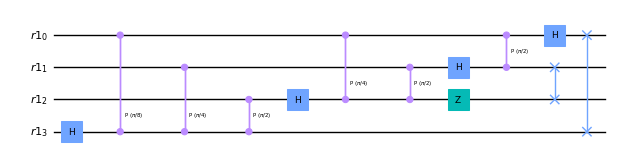

In [151]:
#Circuito iniziale con error
circuit.draw('mpl', fold = -1, scale = 0.5) 

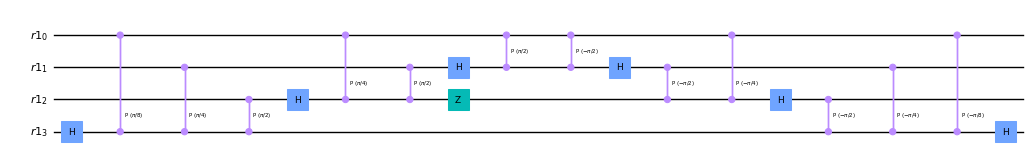

In [150]:
#Circuito andata e ritorno con blocco
merge.draw('mpl', fold = -1, scale = 0.5)

In [144]:
#Circuito integrale inizializzato 
for iii in range(2**n-1, 2**n):   #ciclo sugli stati iniziali
    
    label = bin(iii).lstrip('-0b').zfill(n)
    state = Statevector.from_label(label)
    iii += 1

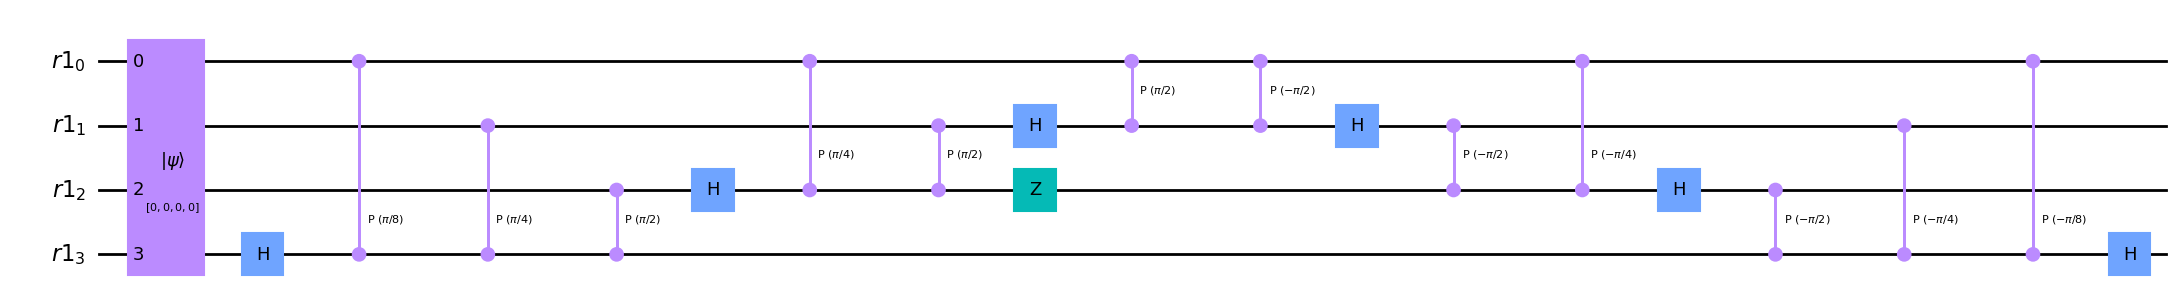

In [148]:
n = 4
control = QuantumRegister(n, 'r1')
initial = QuantumCircuit(control)
initial.initialize('0000')
initial.compose(merge).draw('mpl', fold = -1)

In [147]:
merge.draw('mpl',style={'displaycolor': {'x': ('#05BAB6', '#043813')}}, fold = -1).savefig('circuit_returnP.pdf', format = 'pdf') 


In [141]:
#Matrice Unitaria del circuito UeU
array_to_latex(UeU)

<IPython.core.display.Latex object>

In [159]:
array_to_latex(np.multiply(state, UeU))

<IPython.core.display.Latex object>